<a href="https://colab.research.google.com/github/sin2akshay/External-Internship-Program-2.0-Machine-Learning-for-Deep-Neural-Networks/blob/master/Session%203/Assignment_3A_OptimizedMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

In [0]:
# https://keras.io/
!pip install -q keras
import keras

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils

from keras.datasets import mnist

from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator

#### As is good practice, we next initialize the random number seed with a constant to ensure the results are reproducible.

In [0]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Load pre-shuffled MNIST data into train and test sets

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
print("X_train original shape: ", X_train.shape)
print("y_train original shape: ", y_train.shape)
print("X_test original shape: ", X_test.shape)
print("y_test original shape: ", y_test.shape)

X_train original shape:  (60000, 28, 28)
y_train original shape:  (60000,)
X_test original shape:  (10000, 28, 28)
y_test original shape:  (10000,)


#### Inspecting the data

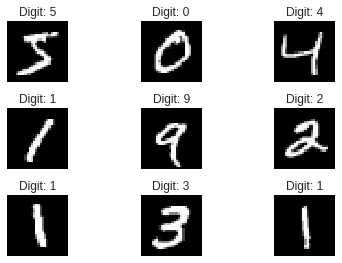

In [0]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

In [0]:
print("Number of training examples = %i" % X_train.shape[0])
print("Number of classes = %i" % len(np.unique(y_train)))
print("Dimension of images = {:d} x {:d}  ".format(X_train[1].shape[0],X_train[1].shape[1])  )

#This line will allow us to know the number of occurrences of each specific class in the data
unique, count= np.unique(y_train, return_counts=True)
print("The number of occurance of each class in the dataset = \n%s " % dict (zip(unique, count) ), "\n" )

Number of training examples = 60000
Number of classes = 10
Dimension of images = 28 x 28  
The number of occurance of each class in the dataset = 
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}  



The input shape that a CNN accepts should be in a specific format. For using Tensorflow, the format should be (batch, height, width, channels). In order to train our neural network to classify images we first have to unroll the height width pixel format into one big vector - the input vector. So its length must be .

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

Now the shape of X_train is (60000, 28, 28, 1). As all the images are in grayscale, the number of channels is 1. If it was a color image, then the number of channels would be 3 (R, G, B).

In [0]:
X_train.shape

(60000, 28, 28, 1)

In [0]:
#Normalizing data to help with training
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

Normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Also, it reduces the chance of getting stuck in local optima, since we're using stochastic gradient descent to find the optimal weights for the network.

In [0]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

Now, we need to [one-hot encode](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) the labels i.e. Y_train and Y_test. In one-hot encoding an integer is converted to an array which contains only one ‘1’ and the rest elements are ‘0’. Thus a '5' will be represented by [0,0,0,0,1,0,0,0,0].

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
Y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

#### Function to help plot image augmentation images later, you can ignore it

In [0]:
def plot_images(imgs, labels=None, rows=1, figsize=(20,8), fontsize=14):
    figure = plt.figure(figsize=figsize)
    cols = max(1,len(imgs) // rows-1)
    labels_present = False
    # checking if labels is a numpy array
    if type(labels).__module__ == np.__name__:
        labels_present=labels.any()
    elif labels:
        labels_present=True
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols+1, i+1)
        # axis off, but leave a bounding box
        plt.tick_params(
            axis='both',
            which='both',
            bottom='off',
            top='off',
            left='off',
            right='off',
            labelbottom='off',
            labelleft='off')
        # plot labels if present
        if labels_present:
            subplot.set_title(labels[i], fontsize=fontsize)
        plt.imshow(imgs[i][:,:,0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

### Creating our Model

In [0]:
from keras.layers import Activation
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(16, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
model.add(BatchNormalization(axis=-1)) #Axis -1 is always the features axis

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(SeparableConv2D(32, (2, 2), activation='relu'))
#BatchNormalization(axis=-1)
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(10, (1, 1), activation='relu'))
model.add(Conv2D(10, (10,10)))
model.add(Flatten())
model.add(Activation('softmax'))

We have used ReLU (rectified linear unit) as our activation function. ReLU function is f(x) = max(0, x), where x is the input. It sets all negative values in the matrix ‘x’ to 0 and keeps all the other values constant. It is the most used activation function since it reduces training time and prevents the problem of vanishing gradients.

---
MaxPooling layer is used to down-sample the input to enable the model to make assumptions about the features so as to reduce over-fitting. It also reduces the number of parameters to learn, reducing the training time.

---
It’s a best practice to always do BatchNormalization. It normalizes the matrix after it is been through a convolution layer so that the scale of each dimension remains the same. It reduces the training time significantly.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_27 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 26, 26, 16)        272       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 13, 13, 16)        64        
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 10, 10, 32)        1184      
__________

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

The cross-entropy loss calculates the error rate between the predicted value and the original value. The formula for calculating cross-entropy loss is given [here](https://en.wikipedia.org/wiki/Cross_entropy). Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used binary_crossentropy.

---

The Adam optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is responsible for updating the weights of the neurons via backpropagation. It calculates the derivative of the loss function with respect to each weight and subtracts it from the weight. **This is how a neural network learns.**

---


### Applying Image Augmentation and visualizing it

In [0]:
datagen = ImageDataGenerator(
        rotation_range=8, 
        width_shift_range=0.08, 
        shear_range=0.3, 
        height_shift_range=0.08, 
        zoom_range=0.08,
        )

test_gen = ImageDataGenerator()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


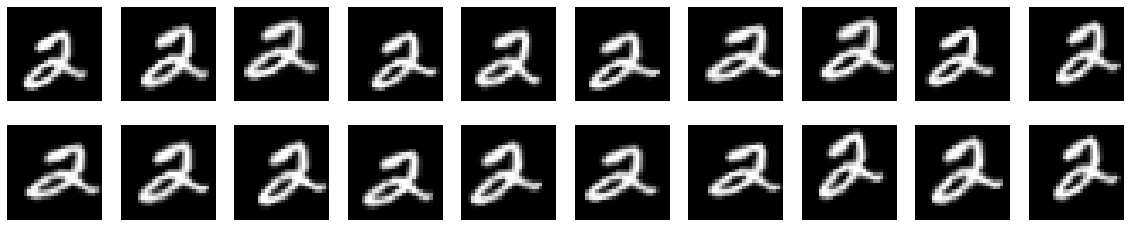

In [0]:
# Visualizing augmented images for a sinle input
img = X_train[5]

batches = 0
max_batches = 20
img_gen = []
for x_batch in datagen.flow(img.reshape((1,) + img.shape), batch_size=max_batches):
    img_gen.append(x_batch[0])
    batches += 1
    if batches >= max_batches:
        # generator loops indefinetly
        break
        
plot_images(img_gen, rows=2, figsize=(20,4))

This is how we can do Data Augmentation in Keras. You can play with the values and check if it improves the accuracy of the model.

---

We have to create batches, so that we use less memory. Moreover, we can also train our model faster by creating batches. If we are using batch of 64, so the model will take 64 images at a time and train on them.

In [0]:
batch_size = 128
train_generator = datagen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

Training Time!!

In [0]:
history = model.fit_generator(train_generator, steps_per_epoch=60000//batch_size, epochs = 50, 
                    validation_data=test_generator, validation_steps=10000//batch_size)

Epoch 1/50
468/468 [==============================] - 22s 48ms/step - loss: 0.0292 - acc: 0.9909 - val_loss: 0.0376 - val_acc: 0.9901
Epoch 2/50
468/468 [==============================] - 23s 48ms/step - loss: 0.0281 - acc: 0.9913 - val_loss: 0.0265 - val_acc: 0.9918
Epoch 3/50
468/468 [==============================] - 23s 48ms/step - loss: 0.0274 - acc: 0.9910 - val_loss: 0.0300 - val_acc: 0.9909
Epoch 4/50
468/468 [==============================] - 23s 49ms/step - loss: 0.0272 - acc: 0.9915 - val_loss: 0.0555 - val_acc: 0.9829
Epoch 5/50
468/468 [==============================] - 23s 49ms/step - loss: 0.0271 - acc: 0.9914 - val_loss: 0.0230 - val_acc: 0.9926
Epoch 6/50
468/468 [==============================] - 22s 48ms/step - loss: 0.0252 - acc: 0.9922 - val_loss: 0.0193 - val_acc: 0.9942
Epoch 7/50
468/468 [==============================] - 23s 48ms/step - loss: 0.0253 - acc: 0.9919 - val_loss: 0.0330 - val_acc: 0.9905
Epoch 8/50
468/468 [==============================] - 23s 49ms

In [0]:
score = model.evaluate(X_test, Y_test)
print()
print('Test accuracy: ', score[1])

10000/10000 [==============================] - 1s 101us/step

Test accuracy:  0.993


In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [0]:
print(score)

[0.024060579517518634, 0.993]


In [0]:
y_pred = model.predict(X_test)

In [0]:
print(y_pred[:9])
print(y_test[:9])

[[1.7787809e-11 3.3920946e-11 1.4321079e-06 5.5202083e-09 7.0594295e-13
  5.3529670e-11 5.5972810e-15 9.9999857e-01 1.4445667e-12 1.3700120e-08]
 [5.1506671e-10 1.7714658e-08 9.9999976e-01 1.6283774e-07 1.8771189e-14
  1.7188073e-13 1.2951425e-08 9.8613051e-10 5.9829240e-08 7.4818996e-12]
 [2.1496635e-07 9.9975866e-01 2.1079556e-08 1.1346560e-09 2.3428311e-04
  7.6481666e-07 3.9081007e-07 4.7391386e-06 1.2019231e-07 8.1445131e-07]
 [9.9977320e-01 2.5673739e-17 1.6809552e-10 1.8948036e-10 1.2272286e-10
  1.8305790e-06 2.2310943e-04 6.6534799e-11 2.0387986e-07 1.6833972e-06]
 [1.3328525e-09 2.3039641e-09 1.0672097e-11 4.5933487e-12 9.9999917e-01
  9.9993252e-12 1.2741294e-11 3.4013628e-10 6.1711608e-10 7.8292112e-07]
 [5.9840090e-08 9.9998093e-01 2.3046884e-08 3.1485026e-11 9.0512294e-06
  5.5069029e-09 2.4688232e-08 8.9109890e-06 2.1505394e-07 7.0635900e-07]
 [1.2084295e-18 4.4015399e-11 7.9279416e-13 4.8560147e-17 9.9999976e-01
  2.9969827e-12 9.5963454e-16 1.9808053e-12 4.5316059e-10 

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

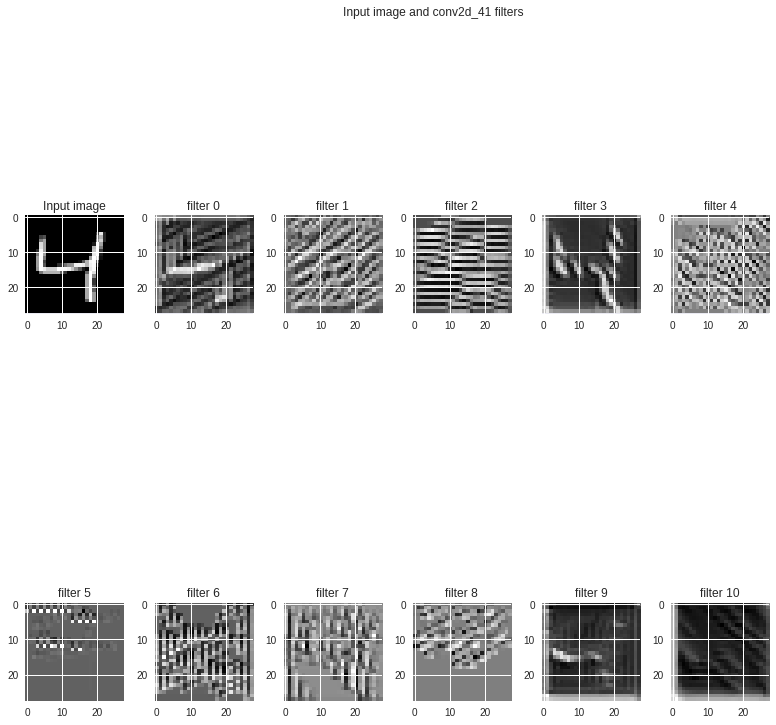

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_41'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()